In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from filters.iekf import IEKF
from tools.objects import Gaussian
from tools import compare, data_processing, transform, utils
from tools.tools_ahrs import plot
import mrob

In [2]:
x3_path = os.path.join("data", "TUM-VI", "imu0")
mocap_path = os.path.join("data", "TUM-VI", "mocap0")
take_name = "outdoors1.csv"

In [3]:
t_base, data_gyr, data_acc = data_processing.import_tum_imu(os.path.join(x3_path, take_name), smoothing=False)

In [4]:
downscale = 1
t_base, data_gyr, data_acc = data_processing.downsample(downscale, t_base, data_gyr, data_acc)

In [5]:
freq_my = 120/downscale # Hz
# if frequency of MoCap is lower than resulting from data - change to MoCap's 240 Hz

In [6]:
data_mocap_t, data_mocap_q, data_mocap_T = data_processing.import_tum_mocap(os.path.join(mocap_path, take_name), smoothing=False)

In [7]:
data_mocap_t, data_mocap_q, data_mocap_T = data_processing.downsample(downscale, data_mocap_t, data_mocap_q, data_mocap_T)

In [8]:
t_base, data_gyr, data_acc, data_acc, data_mocap_q = data_processing.sync_mocap_and_data(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

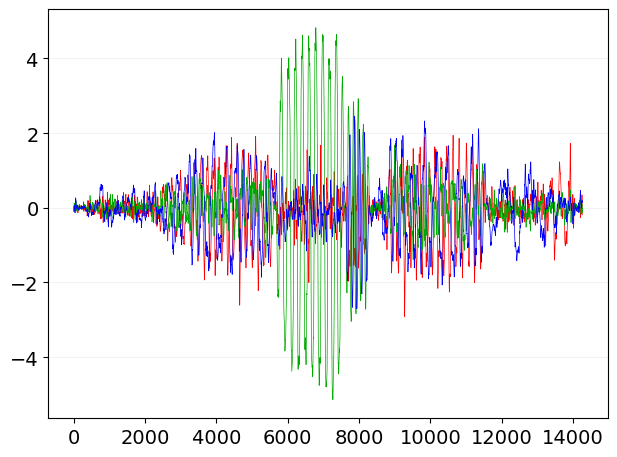

In [9]:
plot(data_gyr)

In [10]:
data_mocap_angvel = transform.quats_to_angvels(data_mocap_t, data_mocap_q)
action_cov = utils.calc_cov(data_gyr[:-1], data_mocap_angvel)
print(action_cov)

[[ 0.08264537 -0.0302371  -0.00395314]
 [-0.0302371   0.06489133  0.00983729]
 [-0.00395314  0.00983729  0.05610179]]


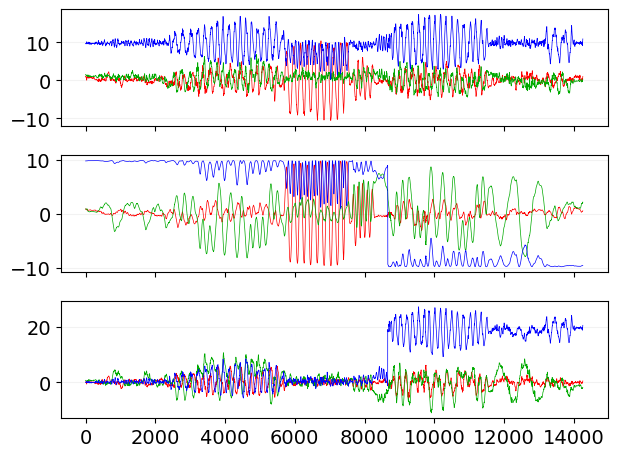

[[ 5.29043319e-01 -4.16697311e-01 -1.71678761e-03]
 [-4.16697311e-01  1.86053181e+00  1.85831833e-01]
 [-1.71678761e-03  1.85831833e-01  2.05695946e-01]]


In [11]:
g = np.array([0, 0, -9.81])
data_mocap_acc = np.array([np.linalg.inv(mrob.quat_to_so3(data_mocap_q[i])) @ g for i in range(len(data_mocap_q))])
start = 0000
end = 2000
measurement_cov = utils.calc_cov(data_acc[start:end], data_mocap_acc[start:end])
plot(data_acc, data_mocap_acc, data_acc - data_mocap_acc)
print(measurement_cov)

# Not so good results with these covs

In [12]:

x3_path_my = os.path.join("data", "X3_simple", "Random_walk_2025-03-06_19-02-36.207_TGW")
# x3_path = "madgwick_filter/recordings/X3_simple/Standing_still_2025-03-06_18-50-19.416_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Basic_motions_2025-03-06_18-45-09.848_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_2025-03-06_18-37-32.144_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Walking_talking_2025-03-06_18-41-53.764_TGW"
# x3_path = "madgwick_filter/recordings/X3_simple/Random_walk_2025-03-06_19-02-36.207_TGW"

mocap_path_my = os.path.join("data", "Mocap_simple", "Random_walk_Take 2025-03-06 06.38.58 PM_004.csv")
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Standing_still_Take 2025-03-06 06.38.58 PM_003.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Basic_motions_Take 2025-03-06 06.38.58 PM_002.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_Take 2025-03-06 06.38.58 PM.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Walking_talking_Take 2025-03-06 06.38.58 PM_001.csv"
# mocap_path = "madgwick_filter/recordings/Mocap_simple/Random_walk_Take 2025-03-06 06.38.58 PM_004.csv"


In [13]:
import_myrecording = False
if import_myrecording:
    t_base, data_gyr, data_acc, data_magn = data_processing.import_combined_data(os.path.join(x3_path_my, "combined_imu_data_7.csv"))
    t_base = t_base/1000
    data_mocap_t, data_mocap_q = data_processing.import_gamerotvec_data(os.path.join(x3_path_my, "game_rotation_vector_12.csv"))
    data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc= data_processing.trim_to_min_length(data_mocap_t, data_mocap_q, t_base, data_gyr, data_acc, data_acc)

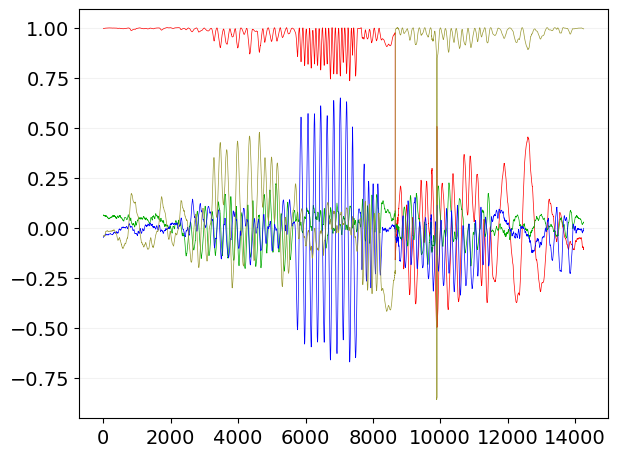

In [14]:
plot(data_mocap_q)

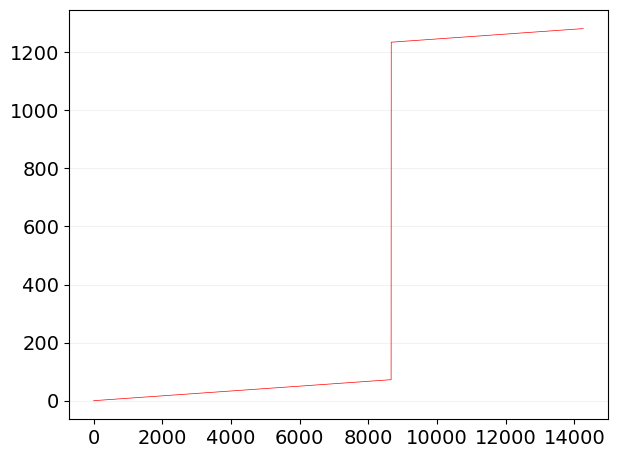

In [15]:
plot(data_mocap_t - data_mocap_t[0])

In [16]:
mean_prior = np.array([0, 0, 0.])
Sigma_prior = 1e1 * np.eye(3, 3)
M = 1e-4 * np.eye(3, 3)                                 # rad/s         ~(0.00122 ** 2) from sensors.csv
Q = 1e-3 * np.eye(3, 3) * (9.81 ** 2)                   # rads * g^2    ~(0.00239 ** 2) from sensors.csv
# worse results with covs from sensors or from np.cov
#M = np.diag(np.diag(action_cov))
#Q = np.diag(np.diag(measurement_cov))
initial_state = Gaussian(mean_prior, Sigma_prior)
g = np.array([0, 0, -9.81])
u_bias = np.array([0, 0, 0.000])
iekf = IEKF(initial_state, M, Q, g, u_bias)
u = data_gyr
N = len(data_gyr)
dts = np.empty(N)
freq_sm = 200
dts[0] = 1/freq_sm
dts[1:] = np.array([t_base[i+1] - t_base[i] for i in range(N-1)])
preds = np.empty((N, 3))
s_preds = np.empty((N, 3, 3))
ups = np.empty((N, 3))
s_ups = np.empty((N, 3, 3))
Ks = np.empty((N, 3, 3))
IVs = np.empty((N, 3))
gt = transform.quats_to_rpy(data_mocap_q)

In [17]:
for i in range(N):
    iekf.predict(u[i], dts[i])
    Ks[i], IVs[i] = iekf.update(data_acc[i])
    #iekf.update_fake()
    preds[i, :] = iekf.mu_bar
    s_preds[i] = iekf.Sigma_bar
    ups[i] = iekf.mu
    s_ups[i] = iekf.Sigma

In [18]:
print(iekf.Sigma_bar)

[[ 2.61136250e-06 -3.02877642e-10  2.40683141e-08]
 [-3.02877642e-10  2.62163197e-06 -2.84399509e-07]
 [ 2.40683141e-08 -2.84399509e-07  1.41521739e-05]]


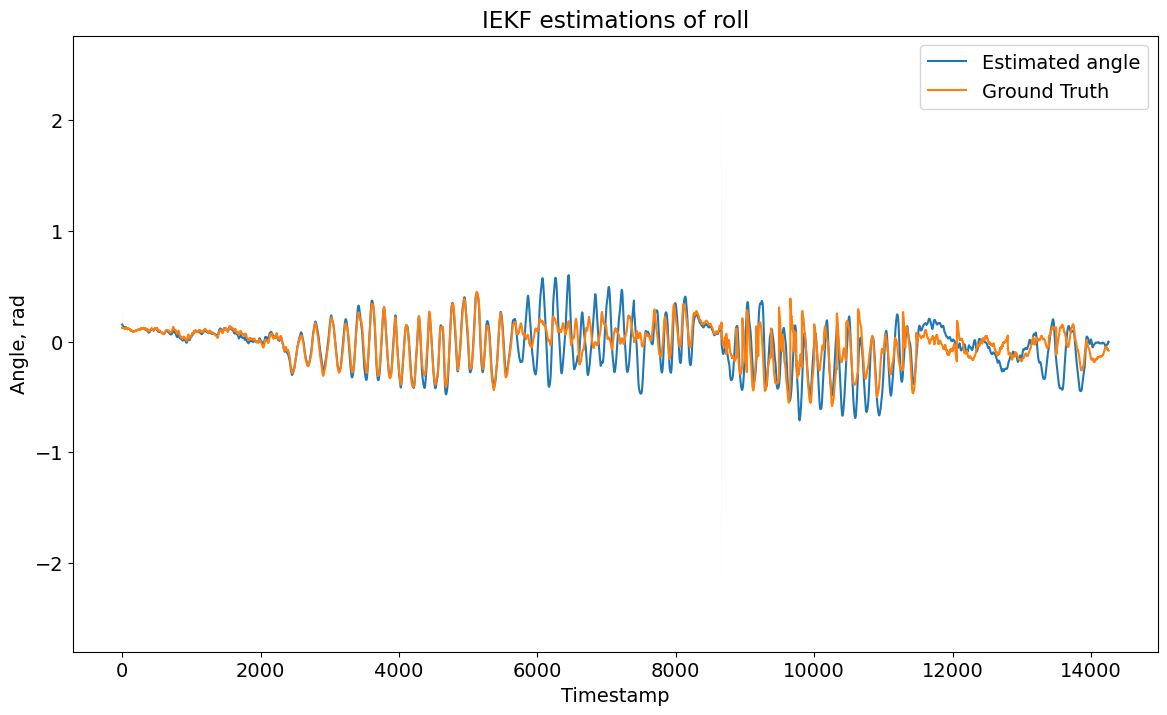

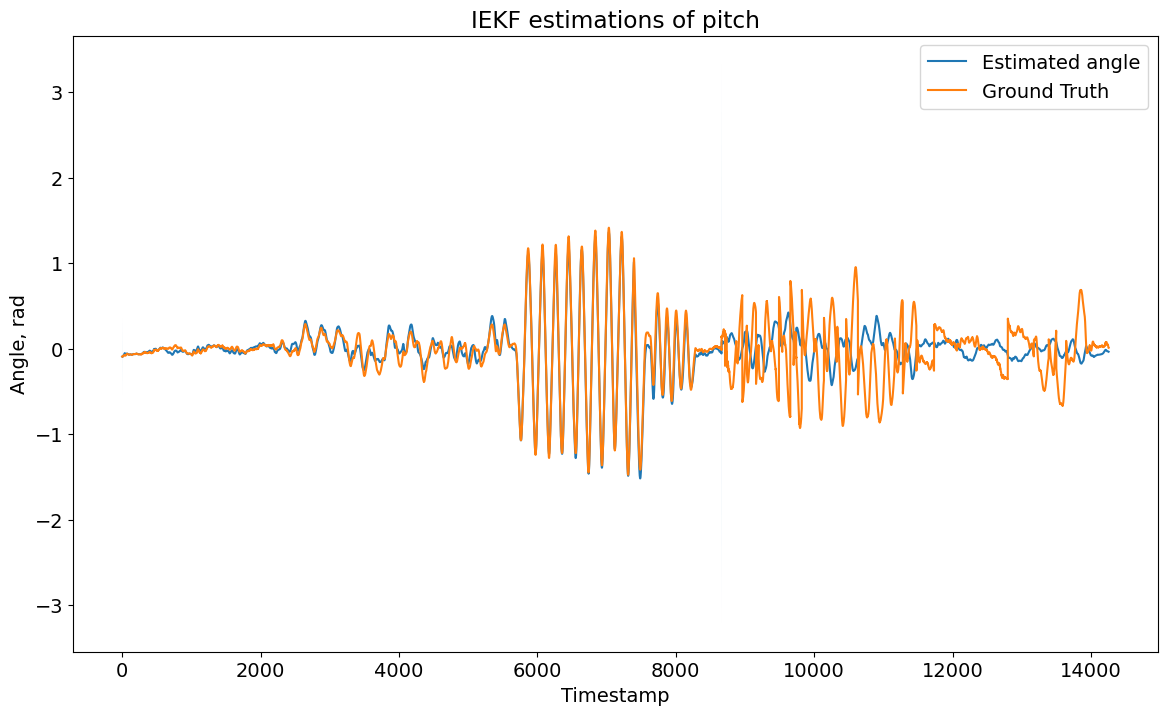

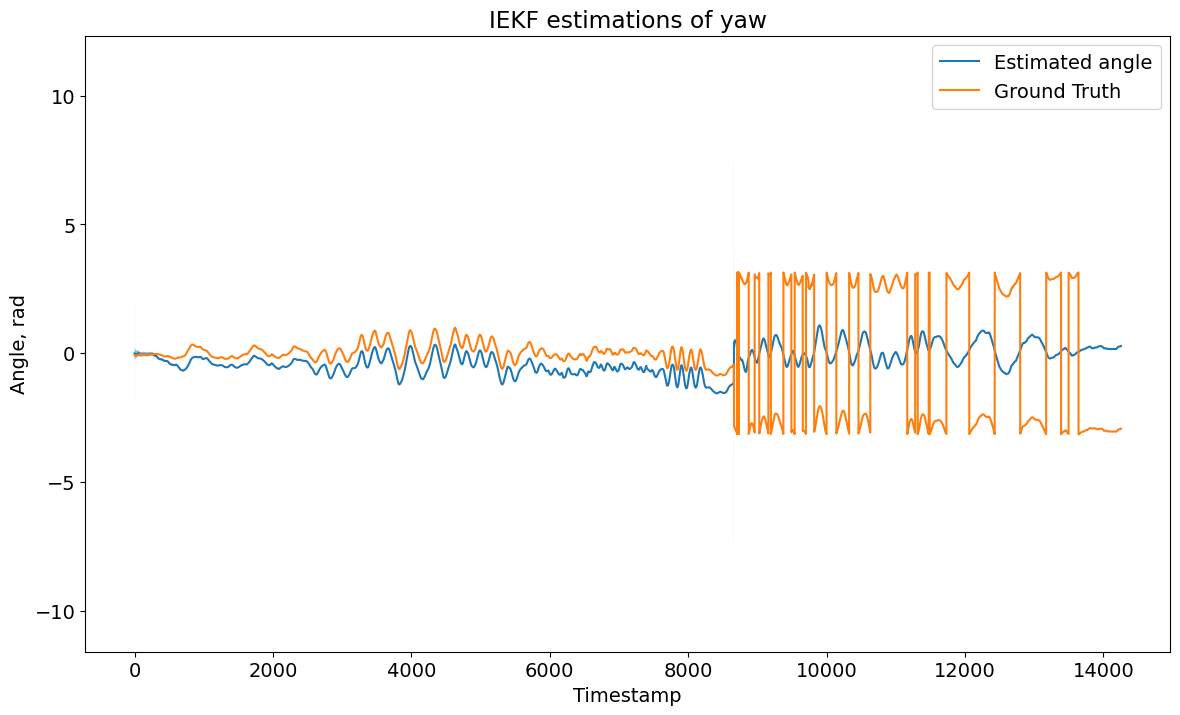

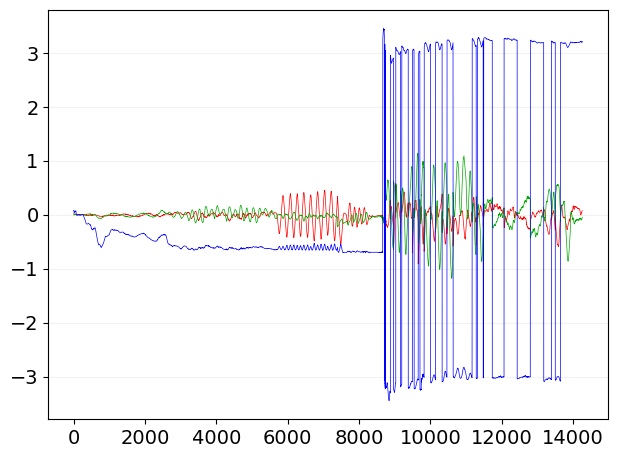

In [19]:
compare.plot_covs(ups, s_ups, 0, gt)
compare.plot_covs(ups, s_ups, 1, gt)
compare.plot_covs(ups, s_ups, 2, gt)
plot(ups - gt)

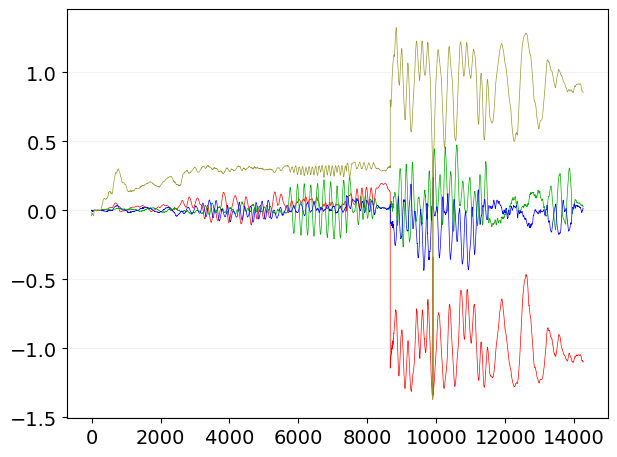

In [20]:
q1 = transform.rpy_to_quats(gt)
q2 = transform.rpy_to_quats(ups)
plot(q1 - q2)

Mean distance between smartphone and mocap attitude estimations:
1.5293345204686652
Distance between smartphone and mocap attitude estimations:


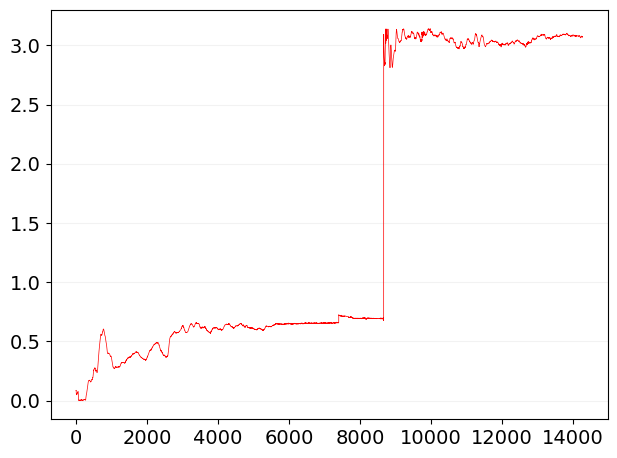

Last distance between smartphone and mocap attitude estimations:
3.072209498394276
Norm of quaternions - shall be = 1
[1. 1. 1. ... 1. 1. 1.]


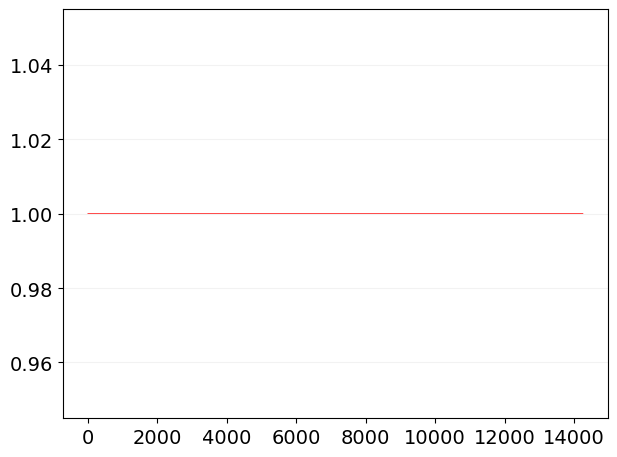

G vectors in smartphone and (mocap-observed-smartphone) reference frames


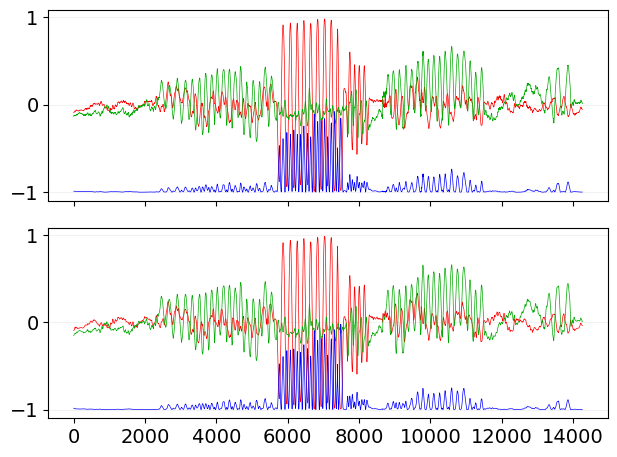

Difference between G vectors in smartphone and (mocap-observed-smartphone) reference frames


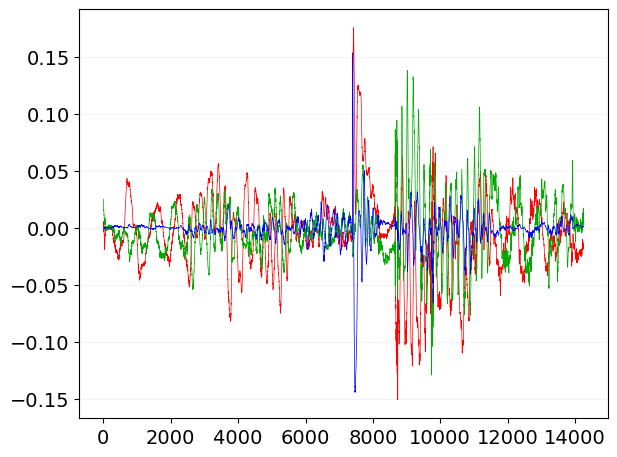

Mean distance between smartphone and mocap vector g estimations:
0.03723813072960826
Distance between smartphone and mocap vector g estimations:


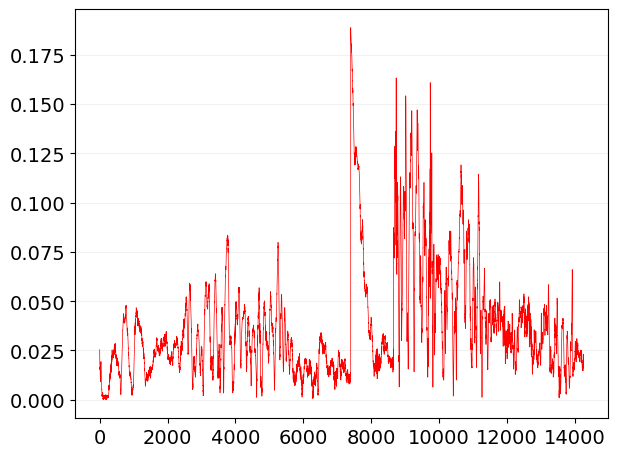

Last distance between smartphone and mocap vector g estimations:
0.019618834253839344
Mean Relative Pose Error
0.0026568991354252625
Relative Pose Error


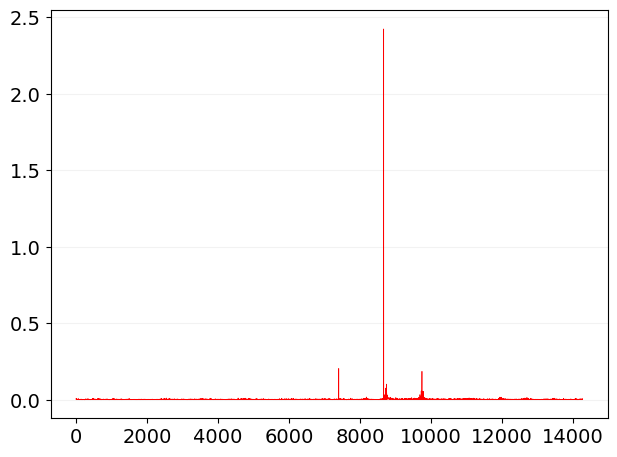

Last RPE between smartphone and mocap attitude estimations:
0.004635243513480683
Mean Relative Pose Error of vector g
0.0079648352078714
Relative Pose Error of vector g


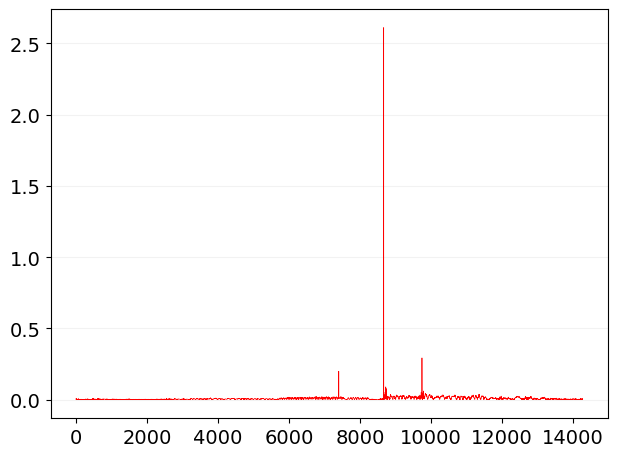

Last RPE between smartphone and mocap vector g estimations:
0.007087456164800823


(array([0.08473281, 0.08822231, 0.08724977, ..., 3.07393411, 3.06925153,
        3.0722095 ]),
 array([0.02539232, 0.02160669, 0.01994972, ..., 0.01612652, 0.01690912,
        0.01961883]),
 array([0.00634846, 0.00217368, 0.00366719, ..., 0.00723806, 0.00486807,
        0.00463524]),
 array([0.00547531, 0.00135014, 0.00322504, ..., 0.003476  , 0.0021009 ,
        0.00708746]))

In [21]:
compare.errors_estimation(q1, q2)